# Stacking Analysis

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u # I use astropy units in everything, very helpful for bookkeeping/debugging

from lim import lim # The base intensity mapping object

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) # Make figures better
#matplotlib.rcParams,update({}'figure.figsize'] = [8,7]

In [2]:
from scipy.ndimage import gaussian_filter

In [3]:
# Initialize LineModel with default model
m = lim()

In [4]:
m_noise = lim('Lichen',doSim=True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


In [5]:
m_noise.tobs

<Quantity 2000. h>

In [6]:
noisy_2 = m_noise.noise_added_map
nonoise_2 = m_noise.maps

Loading .npz catalogues...


In [7]:
m_noise.update(tobs=40000*u.hr)

In [8]:
m_noise.tobs

<Quantity 40000. h>

In [9]:
m_noise.model_name

'LichenCII'

In [10]:
noisy_40 = m_noise.noise_added_map
nonoise_40 = m_noise.maps

Loading .npz catalogues...


In [11]:
m_noise.reset()

In [12]:
m_noise.dnu

<Quantity 2.8 GHz>

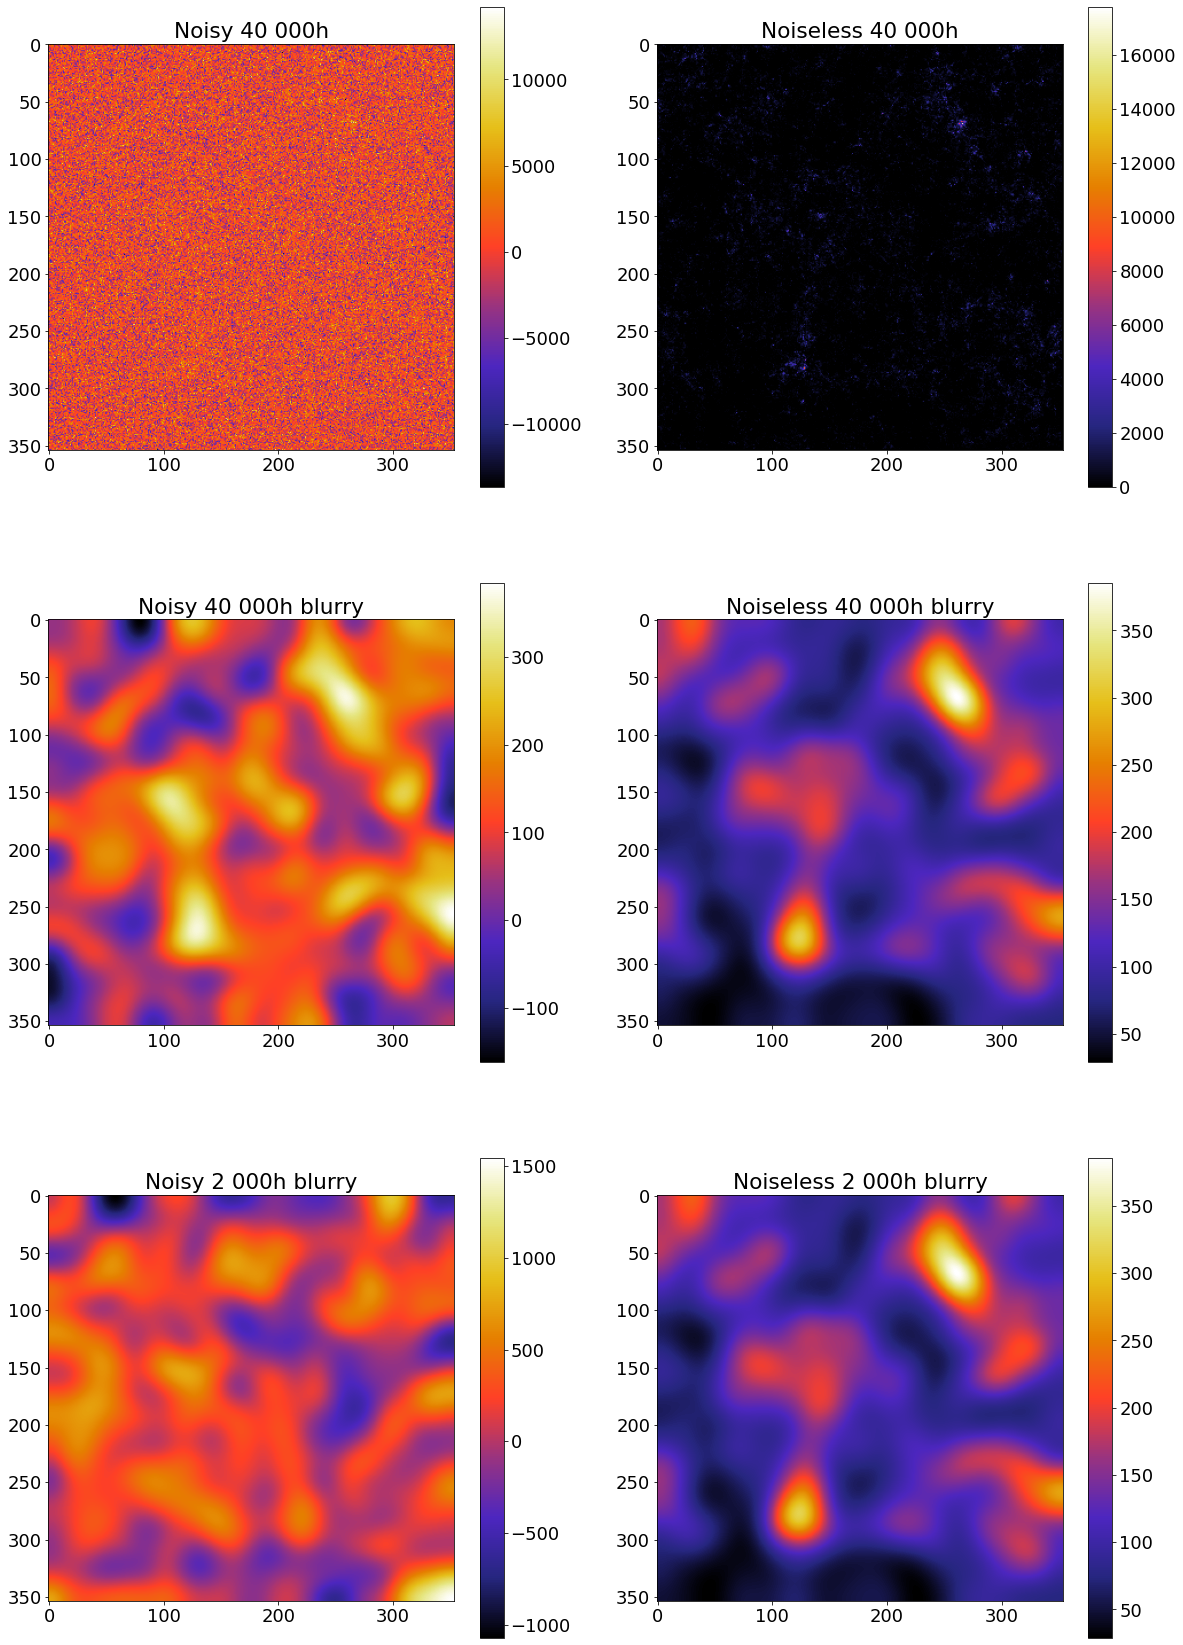

In [13]:
fig , axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

plt.subplot(321)
plt.imshow(noisy_40[:,:,3], cmap = 'CMRmap') 
plt.title('Noisy 40 000h') 
plt.colorbar()

plt.subplot(322)
plt.imshow(nonoise_40[:,:,3], cmap = 'CMRmap') 
plt.title('Noiseless 40 000h')
plt.colorbar()

plt.subplot(323)
plt.imshow(gaussian_filter((noisy_40[...,3]),15), cmap = 'CMRmap') 
plt.title('Noisy 40 000h blurry') 
plt.colorbar()

plt.subplot(324)
plt.imshow(gaussian_filter((nonoise_40[...,3]),15), cmap = 'CMRmap') 
plt.title('Noiseless 40 000h blurry') 
plt.colorbar()

plt.subplot(325)
plt.imshow(gaussian_filter((noisy_2[...,3]),15), cmap = 'CMRmap') 
plt.title('Noisy 2 000h blurry') 
plt.colorbar()

plt.subplot(326)
plt.imshow(gaussian_filter((nonoise_2[...,3]),15), cmap = 'CMRmap') 
plt.title('Noiseless 2 000h blurry') 
plt.colorbar()

# Stacking Analysis

## First in 2D. Take the 2000h noisy map as shown above as our mock map. 

### We have a halo list we would like to correlate to this CII luminosity map. First we will only consider halos above an arbitrary mass threshold

Text(0, 0.5, 'Quantity')

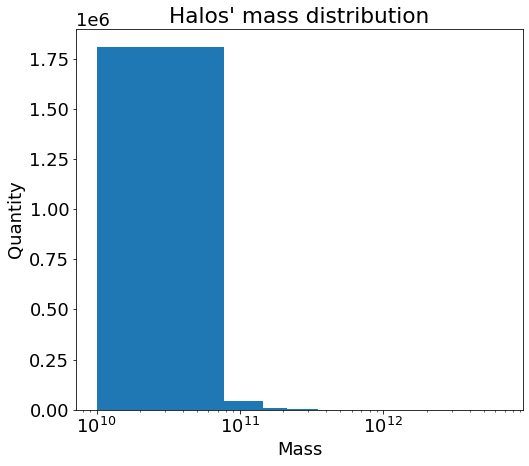

In [107]:
plt.hist(m_noise.halos.M, bins = 100)
plt.xscale('log')
plt.title("Halos' mass distribution")
plt.xlabel('Mass')
plt.ylabel('Quantity')

In [222]:
thresh = m_noise.halos.M > 2*(10**10)
print("So we're considering the", round(100*len(m_noise.halos.M[thresh])/len(m_noise.halos.M)), "% heaviest halos only")

So we're considering the 36 % heaviest halos only


### Array of redshifts for each slice of our cube 

In [223]:
map_zs = (m_noise.mapinst.nu_rest/m_noise.mapinst.nu_bincents) - 1

### Our mock map is at redshift:

In [224]:
map_zs[3] # same index as plotted in mock map

6.025925925925924

### How separated are the redshifts of the 21 maps?

In [225]:
np.ediff1d(map_zs)

array([0.07056729, 0.07204514, 0.0735699 , 0.07514359, 0.07676832,
       0.07844632, 0.08017994, 0.08197167, 0.08382413, 0.08574011,
       0.08772254, 0.08977453, 0.09189937, 0.09410056, 0.09638178,
       0.09874698, 0.10120032, 0.10374624, 0.10638946, 0.10913499])

### So, for now take an uncertainty on the halos we would like to consider on a specific map to be $\pm$ 0.03. Reasonably smaller than than a separation of 0.07.

### So the halos we would like to consider have to be in the 6.026 $\pm$ 0.030 redshift range

In [226]:
halo_zs = m_noise.halos.redshift[thresh] # the array of redshifts for all our halos

In [244]:
err = 0.03 # the error aforementioned
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[3] - err, halo_zs <= map_zs[3] + err)) 

In [248]:
len(halo_zs[good_halo_zs])

38946

### So we will consider 38946 halos on our mock map

In [249]:
halo_xs = m_noise.halos.ra[thresh][good_halo_zs]
halo_ys = m_noise.halos.dec[thresh][good_halo_zs]

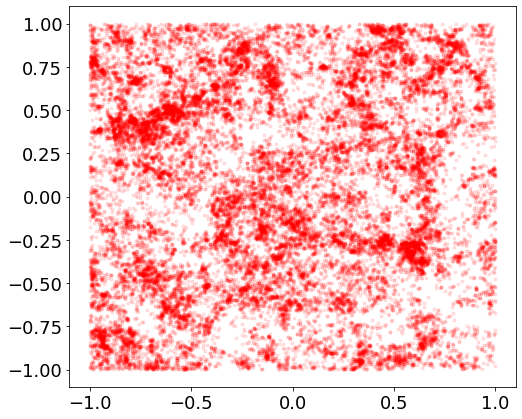

In [250]:
plt.scatter(halo_xs, halo_ys, marker = '.', c = 'r', alpha = 0.1)

### Take for example the first halo on the list. It needs to be mapped on our mapinst object.

In [251]:
np.argmin(np.abs(halo_xs[0] - m_noise.mapinst.pix_bincents_x))

127

In [252]:
np.argmin(np.abs(halo_ys[0] - m_noise.mapinst.pix_bincents_y))

171

### Which means that the closest coordinate corresponding to that first halo is (225, 258) on our 354 by 354 pixel map.

### We want to consider an area around the localization of that halo as the picture of that halo. For now, consider a 5 by 5 pixel map. So our stacked halo map will be a 5 by 5 pixel map, an average of all halos above our mass threshold.

In [253]:
halo_on_mapx = np.array([127 - 2, 127 - 1, 127, 127 + 1, 127 + 2])
halo_on_mapy = np.array([171 - 2, 171 - 1, 171, 171 + 1, 171 + 2])

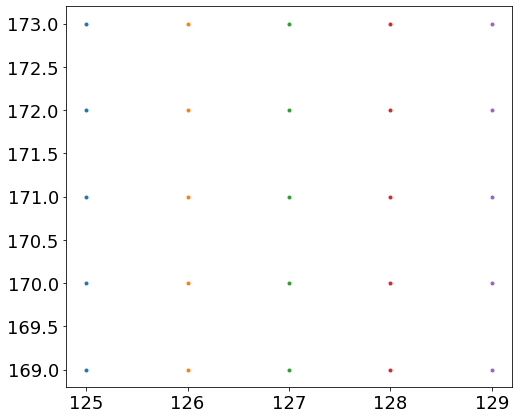

In [254]:
halo_grid = np.meshgrid(halo_on_mapx, halo_on_mapy)
plt.plot(halo_grid[0], halo_grid[1], '.')

In [255]:
# We can pick out, for those pixels on our mapinst map [labeled by the indices in halo_on_mapx/y], the
# luminosities of those pixels

for i in (halo_on_mapx):
    for j in (halo_on_mapy):
        print(m_noise.noise_added_map[i,j,3])

-1622.317630844355
1999.7664514692292
-12044.204857332003
17170.3992216752
1738.1079224198163
-4196.178616055385
-11028.688954373967
-24265.541235870285
2716.7456060104378
-5963.491125751891
8526.773372653794
-4464.346641646258
14429.849296435323
-5238.896740640409
5058.760578451833
14037.297488988452
25908.783143370347
4870.28698012355
-10337.462821764902
10928.215146908417
-1674.8236150568662
3367.774702212625
26469.09810744689
-19781.7247245015
366.7161276068789


## More generally:

In [178]:
# halo_xs/ys are the arrays of positions [in a (-1, 1) range] of all of our 10000 halos
# m_noise.mapinst.pix_bincents_x is the array of all pixel centers [in a (-1, 1) range] of our mapinst map
# so we would like to know, what pixel center is the closest to the position of each halo

In [256]:
halo_centpix_x = [0 for i in range(len(halo_xs))]
halo_centpix_y = [0 for i in range(len(halo_ys))]

for i in range(len(halo_xs)):
    halo_centpix_x[i] = np.argmin(np.abs(halo_xs[i] - m_noise.mapinst.pix_bincents_x))
for i in range(len(halo_ys)):
    halo_centpix_y[i] = np.argmin(np.abs(halo_ys[i] - m_noise.mapinst.pix_bincents_y))

In [161]:
# halo_centpix_x is the array of pixel x-positions for each halo.
# it's essentially the pixel of our map that corresponds to the position of the halo. 
# we will build the stacking map around it.

In [237]:
def halo_centpix(halo_xpos, halo_ypos):
    
    halo_centpix_x = [0 for i in range(len(halo_xpos))]
    halo_centpix_y = [0 for i in range(len(halo_ypos))]

    for i in range(len(halo_xs)):
        halo_centpix_x[i] = np.argmin(np.abs(halo_xpos[i] - m_noise.mapinst.pix_bincents_x))
    for i in range(len(halo_ys)):
        halo_centpix_y[i] = np.argmin(np.abs(halo_ypos[i] - m_noise.mapinst.pix_bincents_y))
        
    return halo_centpix_x, halo_centpix_y   

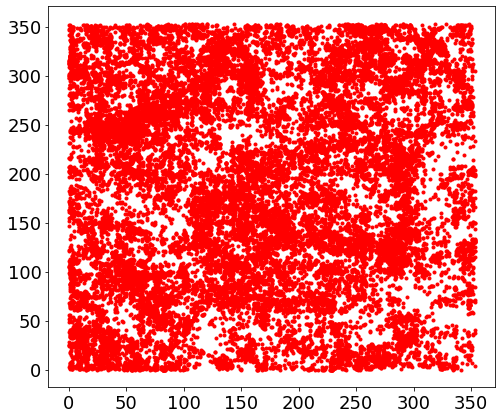

In [257]:
plt.scatter(halo_centpix_x, halo_centpix_y, marker = '.', color = 'r')

In [258]:
n = 5

halo_mapx = [0 for i in range(len(halo_xs))]
halo_mapy = [0 for i in range(len(halo_ys))]

for i in range(len(halo_xs)):
    halo_mapx[i] = np.linspace(halo_centpix_x[i] - (n - 1)/2, halo_centpix_x[i] + (n - 1)/2, n)
for i in range(len(halo_ys)):
    halo_mapy[i] = np.linspace(halo_centpix_y[i] - (n - 1)/2, halo_centpix_y[i] + (n - 1)/2, n)

In [200]:
def halo_map(n, halo_xpos, halo_ypos):
    
    halo_mapx = [0 for i in range(len(halo_xpos))]
    halo_mapy = [0 for i in range(len(halo_ypos))]
    
    halo_centpix_x, halo_centpix_y = halo_centpix(halo_xpos, halo_ypos)

    for i in range(len(halo_xpos)):
        halo_mapx[i] = np.linspace(halo_centpix_x[i] - (n - 1)/2, halo_centpix_x[i] + (n - 1)/2, n)
    for i in range(len(halo_ypos)):
        halo_mapy[i] = np.linspace(halo_centpix_y[i] - (n - 1)/2, halo_centpix_y[i] + (n - 1)/2, n)
    
    return halo_mapx, halo_mapy

In [194]:
# the array halo_on_mapx/y is the array of x/y pixel positions spanned by the n x n map
# it's not a grid, each are a 1D array of length n

In [259]:
lum = [[[[] for i in range(len(halo_mapy[0]))] for j in range(len(halo_mapx[0]))] for k in range(len(halo_xs))]
for i in range(len(halo_xs)):
    for j in range(len(halo_mapx[i])):
        for k in range(len(halo_mapy[i])):
            if int(halo_mapx[i][j]) < 354:
                if int(halo_mapy[i][k]) < 354:
                    lum[i][j][k] = m_noise.noise_added_map[int(halo_mapx[i][j]), int(halo_mapy[i][k]), 3]
                elif int(halo_mapy[i][k]) >= 354:
                    lum[i][j][k] = np.nan
            elif int(halo_mapx[i][j]) >= 354:
                lum[i][j][k] = np.nan

In [201]:
def lum(CII_map, n, halo_xpos, halo_ypos):
    
    halo_mapx, halo_mapy = halo_map(n, halo_xpos, halo_ypos)

    lum = [[[[] for i in range(len(halo_mapy[0]))] for j in range(len(halo_mapx[0]))] for k in range(len(halo_xpos))]
    
    for i in range(len(halo_xpos)):
        for j in range(len(halo_mapx[i])):
            for k in range(len(halo_mapy[i])):
                if int(halo_mapx[i][j]) < 354:
                    if int(halo_mapy[i][k]) < 354:
                        lum[i][j][k] = m_noise.noise_added_map[int(halo_mapx[i][j]), int(halo_mapy[i][k]), 3]
                    elif int(halo_mapy[i][k]) >= 354:
                        lum[i][j][k] = np.nan
                elif int(halo_mapx[i][j]) >= 354:
                    lum[i][j][k] = np.nan
                    
    return lum

In [203]:
np.shape(m_noise.noise_added_map)

(354, 354, 21)

In [260]:
att = np.nanmean(lum, axis=0)

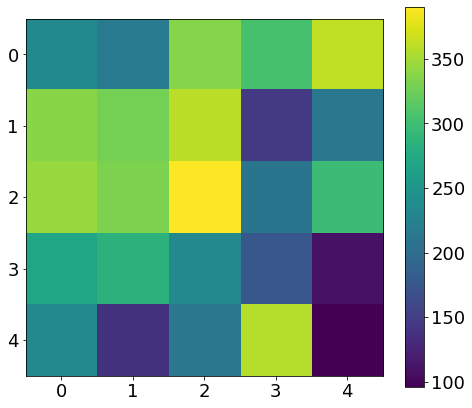

In [261]:
plt.imshow(att)
plt.colorbar()

### Streamlined:

In [264]:
'''

Parameters

llm_obj  : limlam object
           For example, m_noise = lim('Lichen',doSim=True) is the llm_obj here.
           For example, llm_obj.maps for noiseless maps & llm_obj.noise_added_map for noisy map.

mass_cut : float or int
           Lower halo mass cut off (solar masses). 

err      : float
           Uncertainty on the redshift of halos to be accepted on our mock map. 
           For example, our mock map may be at z = 2.062 and a halo at z = 2.061. Might want to accept it.

ind      : int
           Index of the redshift slice taken to be our mockmap. Remember we are doing 2D stacking.
           It can be 0 up to llm_obj.mapinst.nmaps, which is the dimension of the z axis.

'''

llm_obj = lim('Lichen',doSim=True)
mass_cut = 2*(10**10)
err = 0.01
ind = 3

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


Loading .npz catalogues...
We are here considering 13265 halos


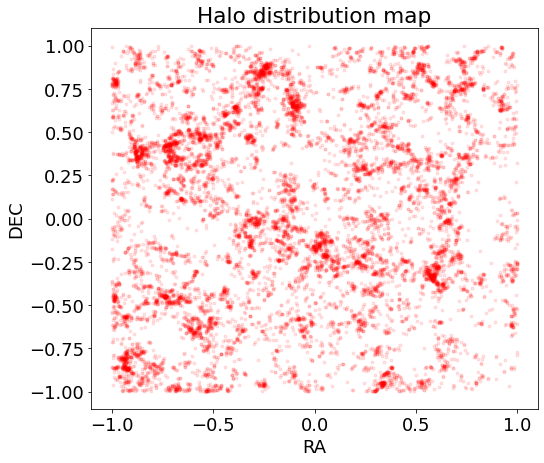

In [428]:
mass_cut = 2*(10**10)

# indices list for massive enough halos
thresh = llm_obj.halos.M > mass_cut

# array of redshifts for each slice of our cube map
map_zs = (llm_obj.mapinst.nu_rest/llm_obj.mapinst.nu_bincents) - 1

# calling the redshifts of all massive enough halos 
halo_zs = llm_obj.halos.redshift[thresh]

# index of halos massive enough + located [redshift-space-wise] close enough to our mock map
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

# x & y positions of the good halos
halo_xs = llm_obj.halos.ra[thresh][good_halo_zs]
halo_ys = llm_obj.halos.dec[thresh][good_halo_zs]

plt.scatter(halo_xs, halo_ys, color = 'r', marker = '.', alpha = 0.1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Halo distribution map')
print('We are here considering', len(halo_xs), 'halos')

npix_x = llm_obj.mapinst.npix_x
npix_y = llm_obj.mapinst.npix_y

In [392]:
def halo_centpix(halo_xpos, halo_ypos):
    
    halo_centpix_x = [0 for i in range(len(halo_xpos))]
    halo_centpix_y = [0 for i in range(len(halo_ypos))]

    for i in range(len(halo_xpos)):
        halo_centpix_x[i] = np.argmin(np.abs(halo_xpos[i] - m_noise.mapinst.pix_bincents_x))
    for i in range(len(halo_ypos)):
        halo_centpix_y[i] = np.argmin(np.abs(halo_ypos[i] - m_noise.mapinst.pix_bincents_y))
        
    return halo_centpix_x, halo_centpix_y  

In [280]:
def halo_map(n, halo_xpos, halo_ypos):
    
    halo_mapx = [0 for i in range(len(halo_xpos))]
    halo_mapy = [0 for i in range(len(halo_ypos))]
    
    halo_centpix_x, halo_centpix_y = halo_centpix(halo_xpos, halo_ypos)

    for i in range(len(halo_xpos)):
        halo_mapx[i] = np.linspace(halo_centpix_x[i] - (n - 1)/2, halo_centpix_x[i] + (n - 1)/2, n)
    for i in range(len(halo_ypos)):
        halo_mapy[i] = np.linspace(halo_centpix_y[i] - (n - 1)/2, halo_centpix_y[i] + (n - 1)/2, n)
    
    return halo_mapx, halo_mapy

In [479]:
def lum(n, halo_xpos, halo_ypos):
    
    halo_mapx, halo_mapy = halo_map(n, halo_xpos, halo_ypos)

    lum_noisy   = [[[[] for i in range(len(halo_mapy[0]))] for j in range(len(halo_mapx[0]))] for k in range(len(halo_xpos))]
    lum_nonoise = [[[[] for i in range(len(halo_mapy[0]))] for j in range(len(halo_mapx[0]))] for k in range(len(halo_xpos))]

    for i in range(len(halo_xpos)):
        for j in range(len(halo_mapx[i])):
            for k in range(len(halo_mapy[i])):
                if int(halo_mapx[i][j]) <= npix_x and int(halo_mapx[i][j]) >= 0:
                    if int(halo_mapy[i][k]) < npix_y and int(halo_mapy[i][k]) >= 0:
                            lum_noisy[i][j][k]   = llm_obj.noise_added_map[int(halo_mapx[i][j]), int(halo_mapy[i][k]), 3]
                            lum_nonoise[i][j][k] = (llm_obj.maps[int(halo_mapx[i][j]), int(halo_mapy[i][k]), 3]).value
                    else:
                        lum_noisy[i][j][k]   = np.nan
                        lum_nonoise[i][j][k] = np.nan
                else:
                    lum_noisy[i][j][k]   = np.nan
                    lum_nonoise[i][j][k] = np.nan
                    
    return lum_noisy, lum_nonoise

In [298]:
noisy_stack = lum(25, halo_xs, halo_ys, noise = True)

In [299]:
noiseless_stack = lum(25, halo_xs, halo_ys, noise = False)

Text(0.5, 0, '$RA-pixels$')

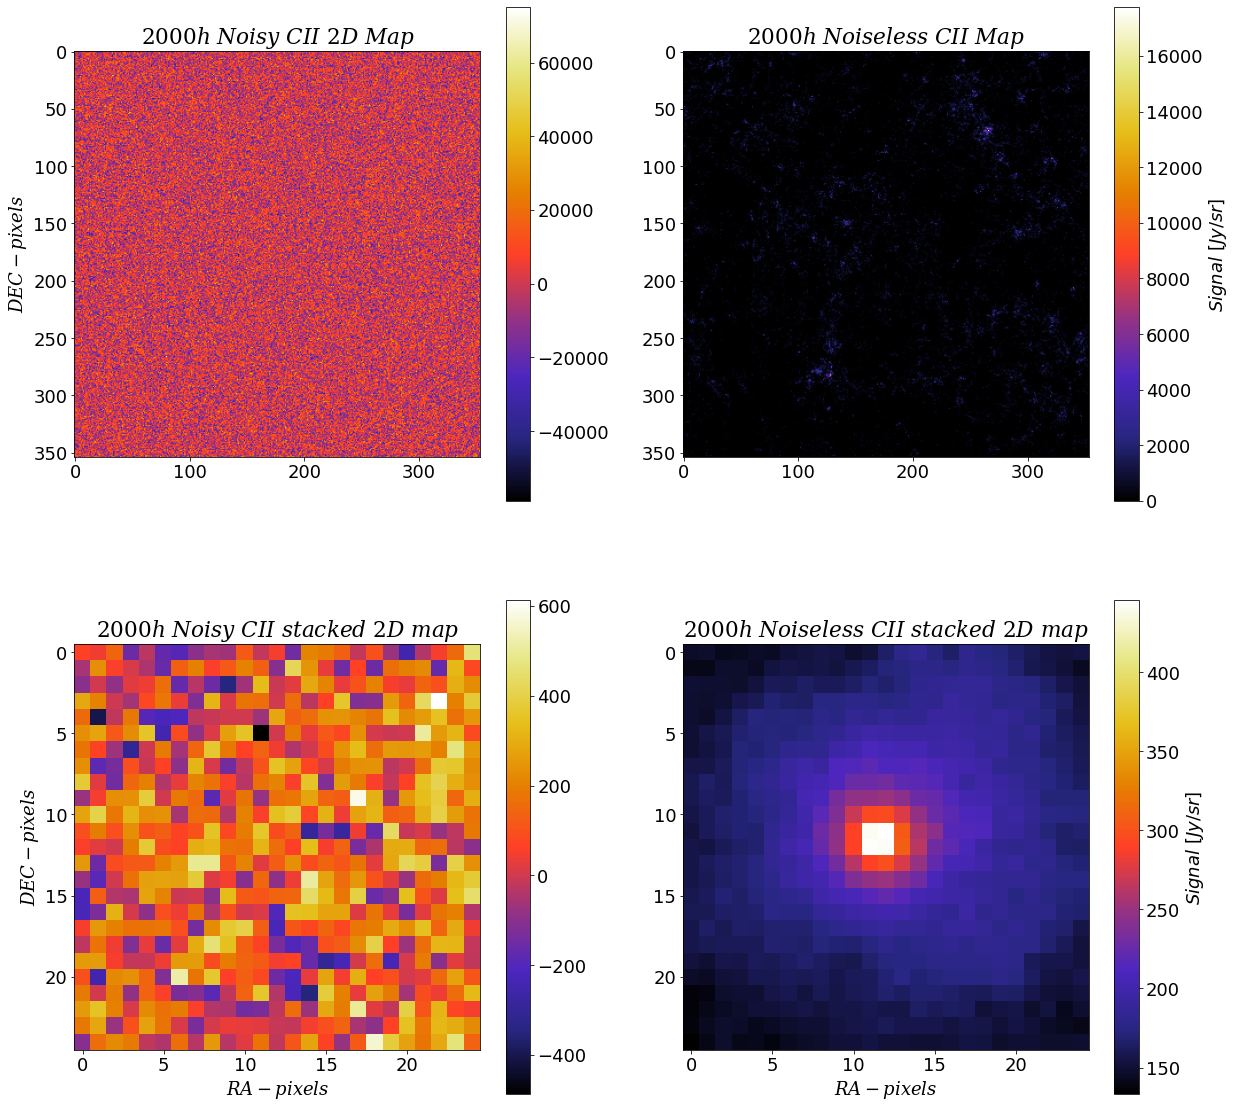

In [327]:
fig , axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))

plt.subplot(221)
plt.imshow(noisy_2[...,3], cmap = 'CMRmap') 
plt.title(r'$2000h\ Noisy\ CII\ 2D\ Map$', math_fontfamily = 'dejavuserif') 
plt.colorbar()
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(222)
plt.imshow(nonoise_2[...,3], cmap = 'CMRmap') 
plt.title(r'$2000h\ Noiseless\ CII\ Map$', math_fontfamily = 'dejavuserif') 
plt.colorbar(label = r'$Signal\ [Jy/sr]$')

plt.subplot(223)
plt.imshow(np.nanmean(noisy_stack, axis = 0), cmap = 'CMRmap')
plt.colorbar()
plt.title(r'$2000h\ Noisy\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(224)
plt.imshow(np.nanmean(noiseless_stack, axis = 0), cmap = 'CMRmap')
plt.colorbar(label = r'$Signal\ [Jy/sr]$')
plt.title(r'$2000h\ Noiseless\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')

In [328]:
llm_obj.update(tobs=40000*u.hr)

In [329]:
llm_obj.tobs

<Quantity 40000. h>

In [330]:
noisy_stack_4 = lum(25, halo_xs, halo_ys, noise = True)

Loading .npz catalogues...
3172.811084920084


In [331]:
noiseless_stack_4 = lum(25, halo_xs, halo_ys, noise = False)

Text(0.5, 0, '$RA-pixels$')

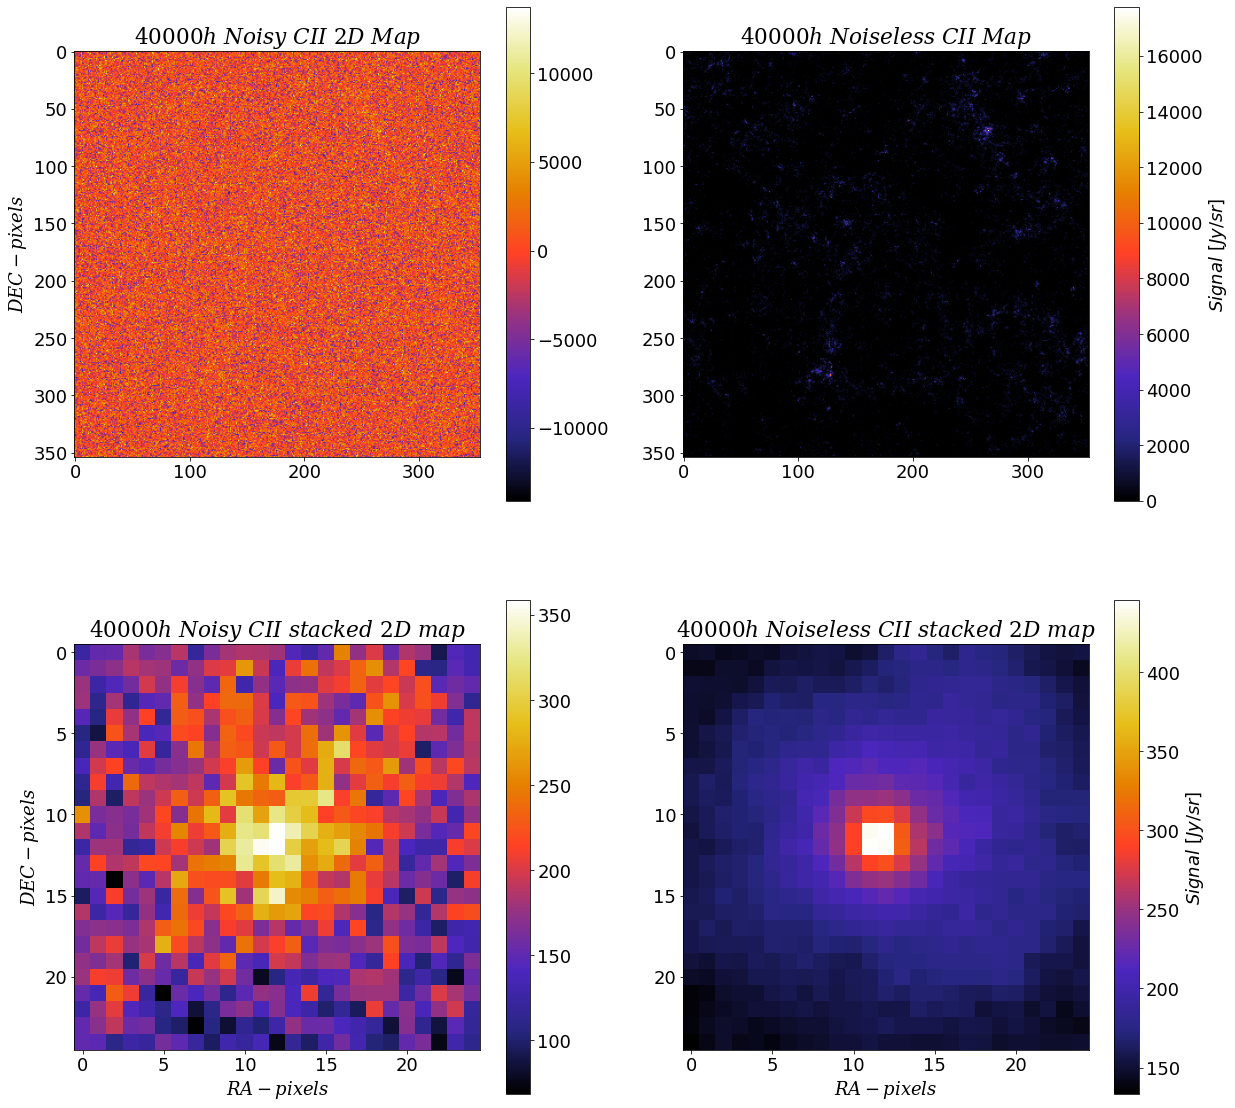

In [334]:
fig , axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))

plt.subplot(221)
plt.imshow(noisy_40[...,3], cmap = 'CMRmap') 
plt.title(r'$40000h\ Noisy\ CII\ 2D\ Map$', math_fontfamily = 'dejavuserif') 
plt.colorbar()
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(222)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.title(r'$40000h\ Noiseless\ CII\ Map$', math_fontfamily = 'dejavuserif') 
plt.colorbar(label = r'$Signal\ [Jy/sr]$')

plt.subplot(223)
plt.imshow(np.nanmean(noisy_stack_4, axis = 0), cmap = 'CMRmap')
plt.colorbar()
plt.title(r'$40000h\ Noisy\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

plt.subplot(224)
plt.imshow(np.nanmean(noiseless_stack_4, axis = 0), cmap = 'CMRmap')
plt.colorbar(label = r'$Signal\ [Jy/sr]$')
plt.title(r'$40000h\ Noiseless\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')

In [337]:
llm_obj.reset()

In [338]:
llm_obj.tobs

<Quantity 2000. h>

## Mass Cutoff Investigation

### Mass cutoff: $3 \times 10^{10} M_{\odot}$

We are here considering 6748 halos


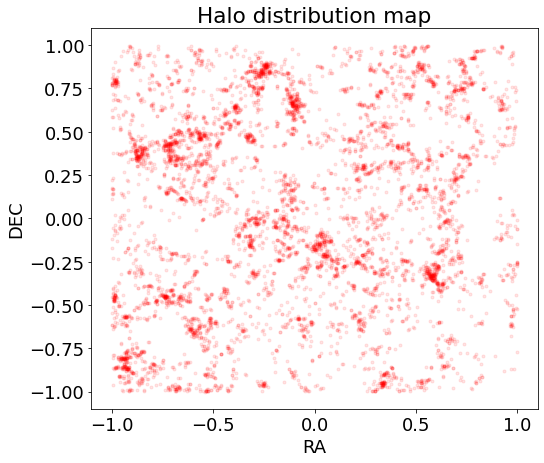

In [386]:
mass_cut = 3*(10**10)

# indices list for massive enough halos
thresh = llm_obj.halos.M > mass_cut

# array of redshifts for each slice of our cube map
map_zs = (llm_obj.mapinst.nu_rest/llm_obj.mapinst.nu_bincents) - 1

# calling the redshifts of all massive enough halos 
halo_zs = llm_obj.halos.redshift[thresh]

# index of halos massive enough + located [redshift-space-wise] close enough to our mock map
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

# x & y positions of the good halos
halo_xs_m1 = llm_obj.halos.ra[thresh][good_halo_zs]
halo_ys_m1 = llm_obj.halos.dec[thresh][good_halo_zs]

plt.scatter(halo_xs_m1, halo_ys_m1, color = 'r', marker = '.', alpha = 0.1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Halo distribution map')
print('We are here considering', len(halo_xs_m1), 'halos')

npix_x = llm_obj.mapinst.npix_x
npix_y = llm_obj.mapinst.npix_y

In [340]:
noisy_stack_m1 = lum(25, halo_xs, halo_ys, noise = True)

14189.242531292331


In [341]:
noiseless_stack_m1 = lum(25, halo_xs, halo_ys, noise = False)

### Mass cutoff: $4 \times 10^{10} M_{\odot}$

We are here considering 4191 halos


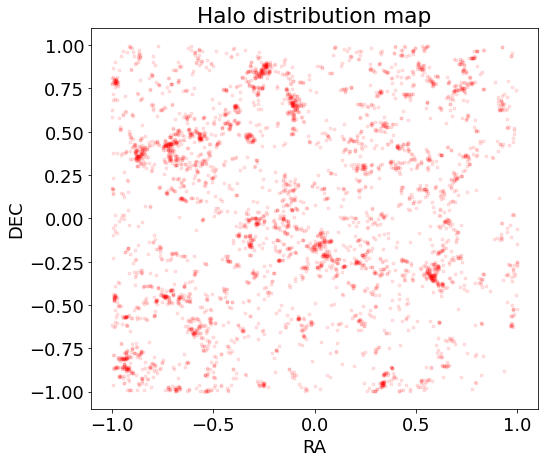

In [387]:
mass_cut = 4*(10**10)

# indices list for massive enough halos
thresh = llm_obj.halos.M > mass_cut

# array of redshifts for each slice of our cube map
map_zs = (llm_obj.mapinst.nu_rest/llm_obj.mapinst.nu_bincents) - 1

# calling the redshifts of all massive enough halos 
halo_zs = llm_obj.halos.redshift[thresh]

# index of halos massive enough + located [redshift-space-wise] close enough to our mock map
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

# x & y positions of the good halos
halo_xs_m2 = llm_obj.halos.ra[thresh][good_halo_zs]
halo_ys_m2 = llm_obj.halos.dec[thresh][good_halo_zs]

plt.scatter(halo_xs_m2, halo_ys_m2, color = 'r', marker = '.', alpha = 0.1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Halo distribution map')
print('We are here considering', len(halo_xs_m2), 'halos')

npix_x = llm_obj.mapinst.npix_x
npix_y = llm_obj.mapinst.npix_y

In [345]:
noisy_stack_m2 = lum(25, halo_xs, halo_ys, noise = True)
noiseless_stack_m2 = lum(25, halo_xs, halo_ys, noise = False)

### Mass cutoff: $5 \times 10^{10} M_{\odot}$

We are here considering 2879 halos


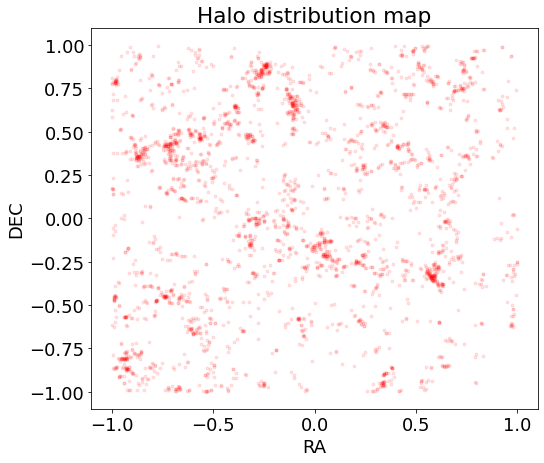

In [388]:
mass_cut = 5*(10**10)

# indices list for massive enough halos
thresh = llm_obj.halos.M > mass_cut

# array of redshifts for each slice of our cube map
map_zs = (llm_obj.mapinst.nu_rest/llm_obj.mapinst.nu_bincents) - 1

# calling the redshifts of all massive enough halos 
halo_zs = llm_obj.halos.redshift[thresh]

# index of halos massive enough + located [redshift-space-wise] close enough to our mock map
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

# x & y positions of the good halos
halo_xs_m3 = llm_obj.halos.ra[thresh][good_halo_zs]
halo_ys_m3 = llm_obj.halos.dec[thresh][good_halo_zs]

plt.scatter(halo_xs_m3, halo_ys_m3, color = 'r', marker = '.', alpha = 0.1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Halo distribution map')
print('We are here considering', len(halo_xs_m3), 'halos')

npix_x = llm_obj.mapinst.npix_x
npix_y = llm_obj.mapinst.npix_y

In [347]:
noisy_stack_m3 = lum(25, halo_xs, halo_ys, noise = True)
noiseless_stack_m3 = lum(25, halo_xs, halo_ys, noise = False)

### Mass cutoff: $6 \times 10^{10} M_{\odot}$

We are here considering 2092 halos


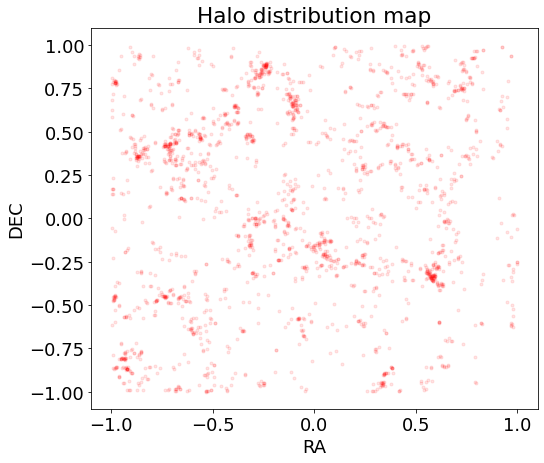

In [389]:
mass_cut = 6*(10**10)

# indices list for massive enough halos
thresh = llm_obj.halos.M > mass_cut

# array of redshifts for each slice of our cube map
map_zs = (llm_obj.mapinst.nu_rest/llm_obj.mapinst.nu_bincents) - 1

# calling the redshifts of all massive enough halos 
halo_zs = llm_obj.halos.redshift[thresh]

# index of halos massive enough + located [redshift-space-wise] close enough to our mock map
good_halo_zs = np.where(np.logical_and(halo_zs >= map_zs[ind] - err, halo_zs <= map_zs[ind] + err)) 

# x & y positions of the good halos
halo_xs_m4 = llm_obj.halos.ra[thresh][good_halo_zs]
halo_ys_m4 = llm_obj.halos.dec[thresh][good_halo_zs]

plt.scatter(halo_xs_m4, halo_ys_m4, color = 'r', marker = '.', alpha = 0.1)
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Halo distribution map')
print('We are here considering', len(halo_xs_m4), 'halos')

npix_x = llm_obj.mapinst.npix_x
npix_y = llm_obj.mapinst.npix_y

In [349]:
noisy_stack_m4 = lum(25, halo_xs, halo_ys, noise = True)
noiseless_stack_m4 = lum(25, halo_xs, halo_ys, noise = False)

In [393]:
halo_centpix_x, halo_centpix_y = halo_centpix(halo_xs, halo_ys)
halo_centpix_x_m1, halo_centpix_y_m1 = halo_centpix(halo_xs_m1, halo_ys_m1)
halo_centpix_x_m2, halo_centpix_y_m2 = halo_centpix(halo_xs_m2, halo_ys_m2)
halo_centpix_x_m3, halo_centpix_y_m3 = halo_centpix(halo_xs_m3, halo_ys_m3)
halo_centpix_x_m4, halo_centpix_y_m4 = halo_centpix(halo_xs_m4, halo_ys_m4)

Text(0.5, 1.0, '$2000h\\ Noiseless\\ CII\\ Map$')

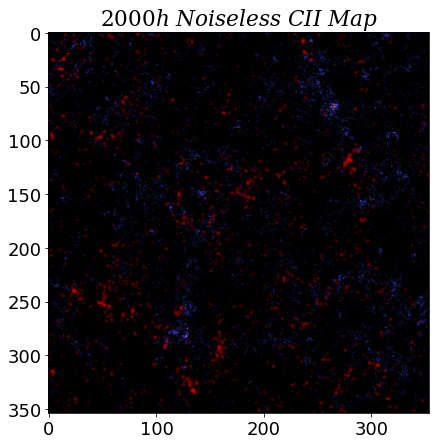

In [385]:
fig , axes = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 30))

plt.subplot()
plt.imshow(nonoise_2[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title(r'$2000h\ Noiseless\ CII\ Map$', math_fontfamily = 'dejavuserif') 

Text(0.5, 1.0, 'M4')

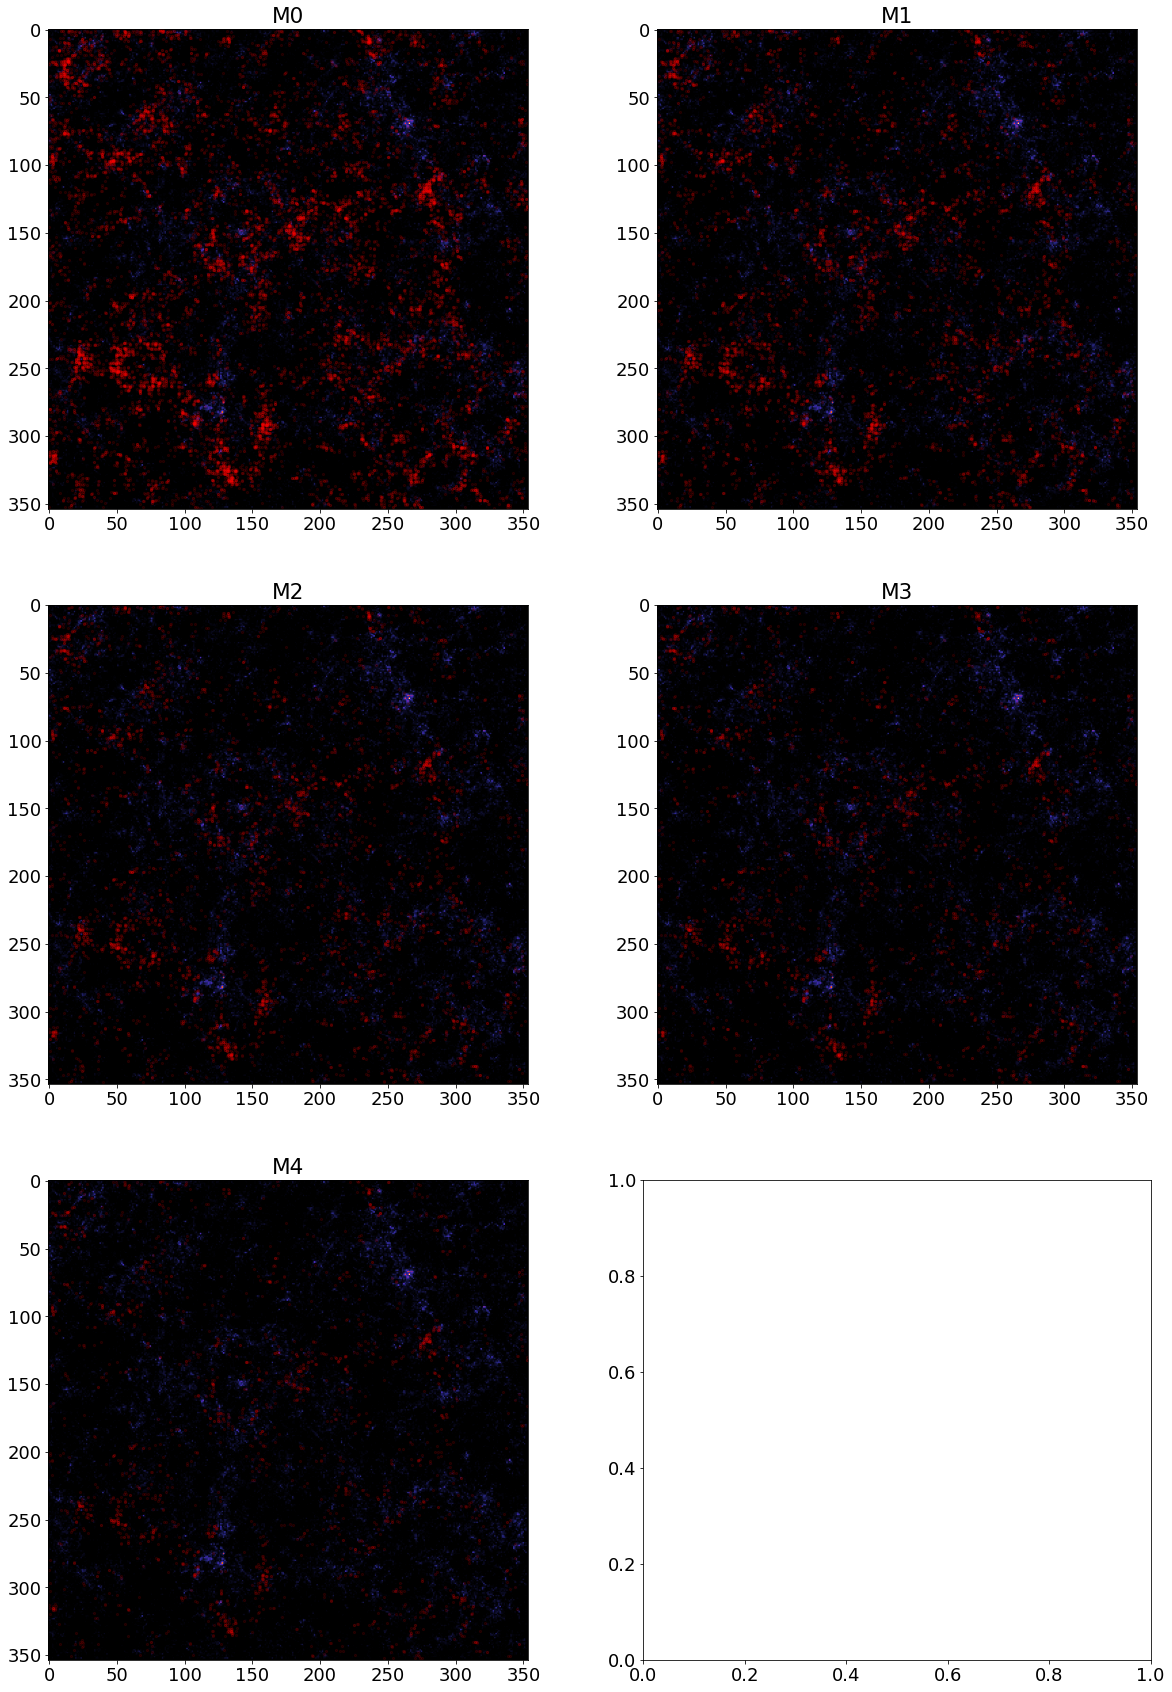

In [395]:
fig , axes = plt.subplots(nrows=3, ncols=2, figsize=(20,30))

plt.subplot(321)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x, halo_centpix_y, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title('M0') 

plt.subplot(322)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x_m1, halo_centpix_y_m1, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title('M1')

plt.subplot(323)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x_m2, halo_centpix_y_m2, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title('M2')

plt.subplot(324)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x_m3, halo_centpix_y_m3, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title('M3')

plt.subplot(325)
plt.imshow(nonoise_40[...,3], cmap = 'CMRmap') 
plt.scatter(halo_centpix_x_m4, halo_centpix_y_m4, color = 'r', marker = 'o', alpha = 0.1, s = 5)
plt.title('M4')

#plt.subplot(326)
#plt.imshow(gaussian_filter((nonoise_2[...,3]),15), cmap = 'CMRmap') 
#plt.title('Noiseless 2 000h blurry') 
#plt.colorbar()

### Will come back to that later. For now, focus on Wiener Filtering

### Making the movie:

In [462]:
import imageio

consider a single mass cut, redshift error and redshift index. We will run different $t_{obs}$ and everytime record the stacked map. Once we have our maps we can try to put them together in a .gif file

In [410]:
mass_cut = 2*(10**10)
err = 0.01
ind = 3

In [431]:
t_obs_arr = np.logspace(np.log10(2000), 5, 5)

In [434]:
noisy_stacks     = [[] for i in range(len(t_obs_arr))]
noiseless_stacks = [[] for i in range(len(t_obs_arr))]

for i in range(len(t_obs_arr)):

    llm_obj.update(tobs = (t_obs_arr[i])*u.hr)
    
    noisy_stacks[i]     = lum(25, halo_xs, halo_ys, noise = True)
    noiseless_stacks[i] = lum(25, halo_xs, halo_ys, noise = False)

Loading .npz catalogues...
14189.24253129233
Loading .npz catalogues...
8701.376518045812
Loading .npz catalogues...
5336.010935173095
Loading .npz catalogues...
3272.2423447872397
Loading .npz catalogues...
2006.6619227554763


In [438]:
plt.imshow(noisy_stacks[0][...,3])

TypeError: list indices must be integers or slices, not tuple

In [439]:
noisy_stacks[0][...,3]

TypeError: list indices must be integers or slices, not tuple

In [440]:
np.shape(noisy_stacks)

(5, 13265, 25, 25)

In [441]:
np.shape(noisy_stack)

(13265, 25, 25)

In [459]:
t_obs_arr[4]

100000.0

Text(0, 0.5, '$DEC-pixels$')

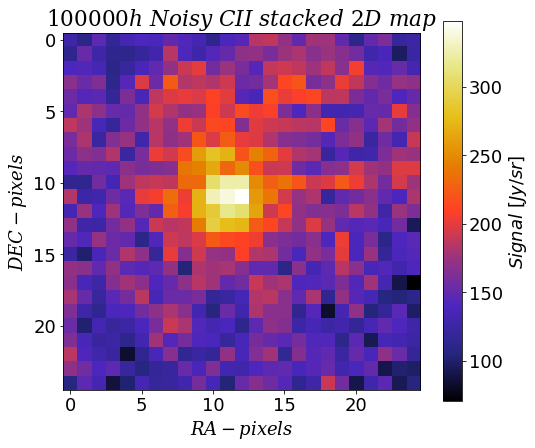

In [461]:
plt.imshow(np.nanmean(noisy_stacks[4], axis = 0), cmap = 'CMRmap')
plt.colorbar(label = r'$Signal\ [Jy/sr]$')
plt.title(r'$100000h\ Noisy\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')

#plt.savefig('5.png')
#plt.show()

In [463]:
with imageio.get_writer('stacks.gif', mode='I') as writer:
    for filename in ['1.png', '2.png', '3.png', '4.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_962850/302832322.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


Now, more ambitious:

In [470]:
t_obs_arr_2 = np.logspace(np.log10(2000), 5, 50)

In [506]:
noisy_stacks_mov     = [[] for i in range(len(t_obs_arr_2))]
noiseless_stacks_mov = [[] for i in range(len(t_obs_arr_2))]

for i in range(len(t_obs_arr_2)):

    llm_obj.update(tobs = (t_obs_arr_2[i])*u.hr)
    
    noisy_stacks_mov[i], noiseless_stacks_mov[i] = lum(25, halo_xs, halo_ys)

Loading .npz catalogues...
14189.24253129233
Loading .npz catalogues...
13633.984106197699
Loading .npz catalogues...
13100.45424892186
Loading .npz catalogues...
12587.802669513123
Loading .npz catalogues...
12095.212351864975
Loading .npz catalogues...
11621.898251632301
Loading .npz catalogues...
11167.106045101198
Loading .npz catalogues...
10730.110927018392
Loading .npz catalogues...
10310.216455464504
Loading .npz catalogues...
9906.753441930081
Loading .npz catalogues...
9519.07888482559
Loading .npz catalogues...
9146.574944725664
Loading .npz catalogues...
8788.647959714444
Loading .npz catalogues...
8444.727499262792
Loading .npz catalogues...
8114.26545512949
Loading .npz catalogues...
7796.73516783764
Loading .npz catalogues...
7491.630587334062
Loading .npz catalogues...
7198.465466494095
Loading .npz catalogues...
6916.772586186441
Loading .npz catalogues...
6646.103010663029
Loading .npz catalogues...
6386.025372087254
Loading .npz catalogues...
6136.125183060277
Loadin

In [510]:
np.shape(noisy_stacks_mov[49])

(13265, 25, 25)

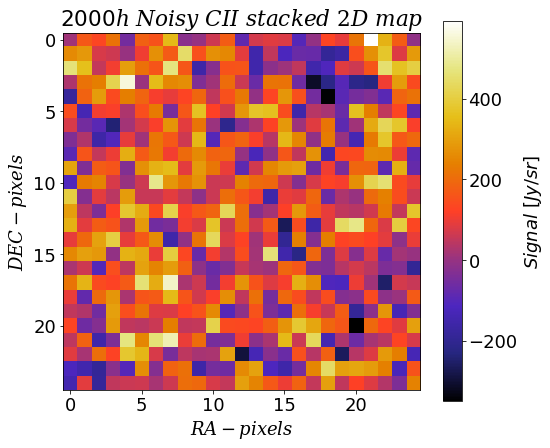

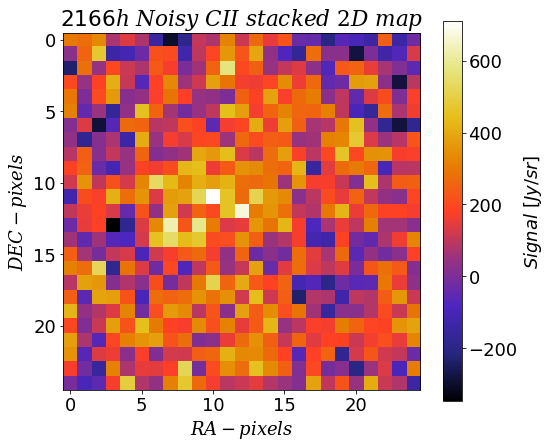

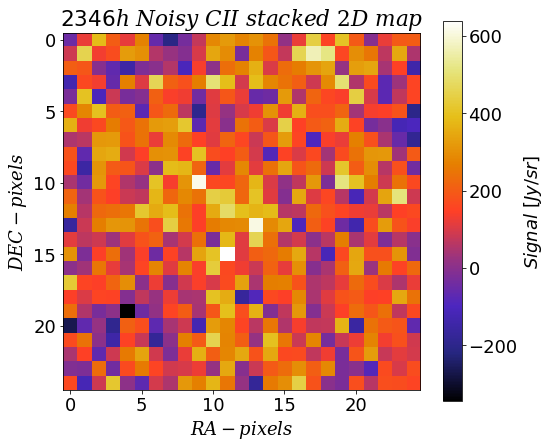

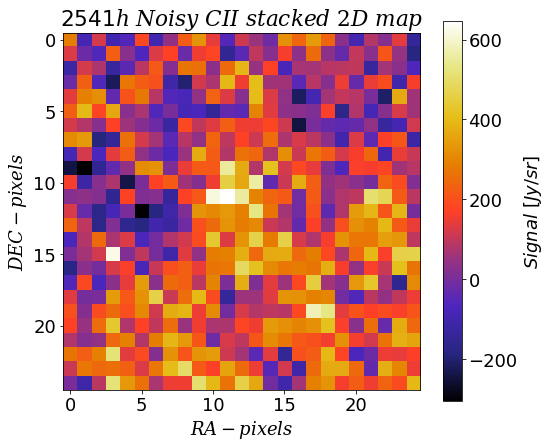

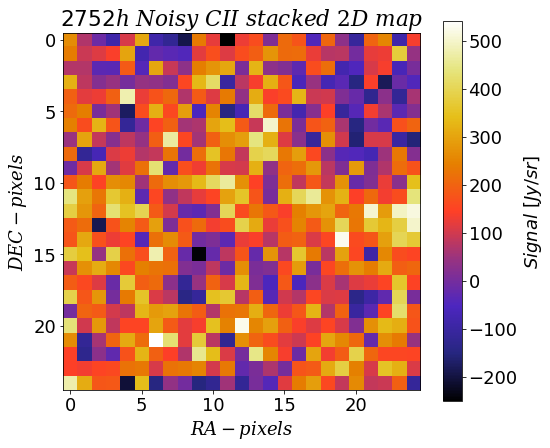

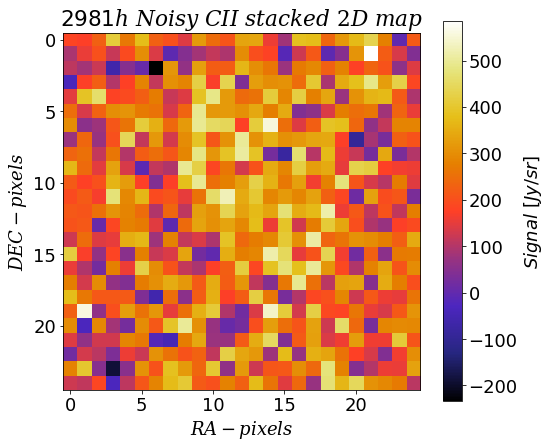

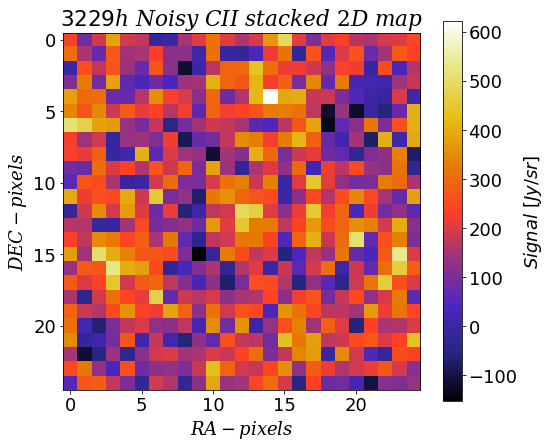

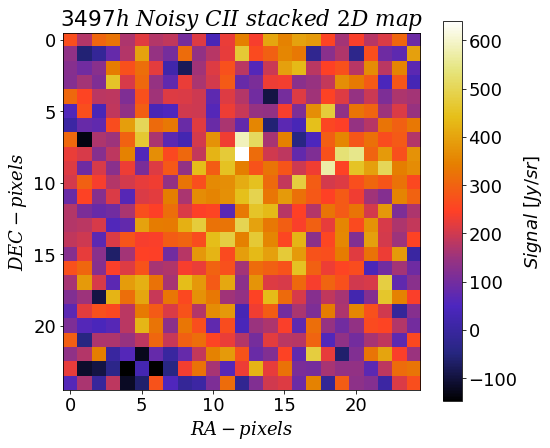

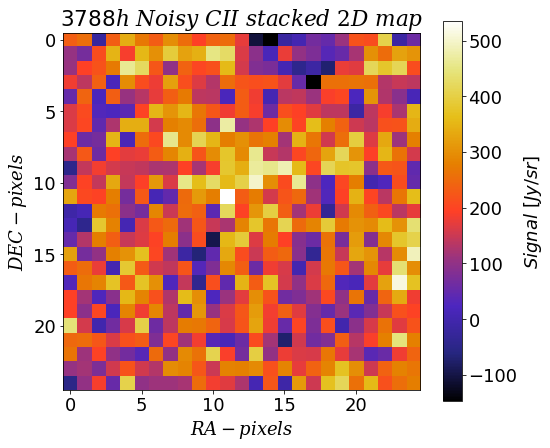

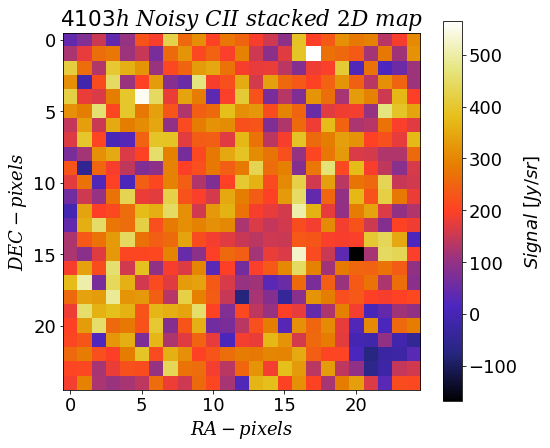

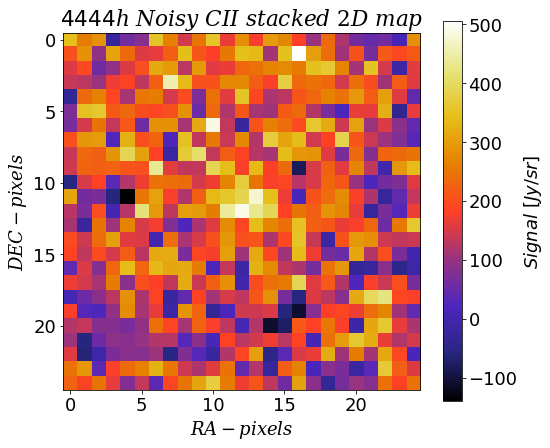

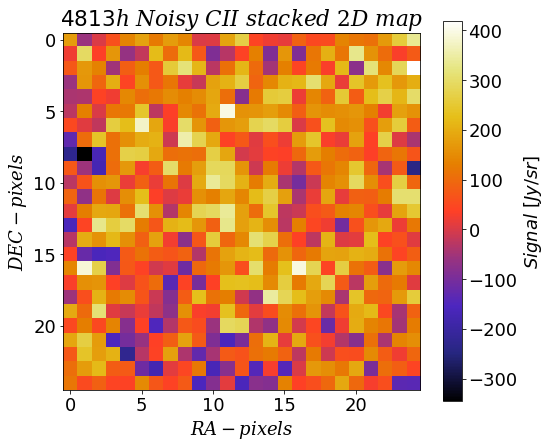

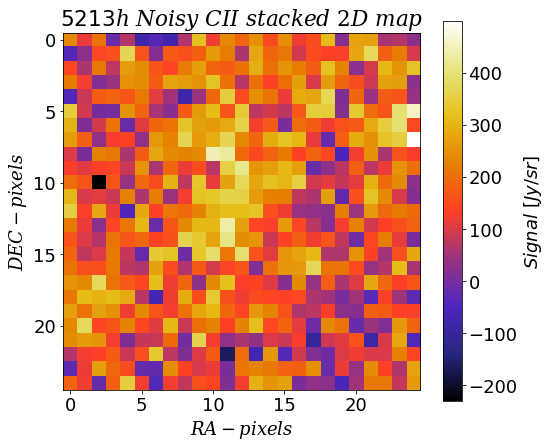

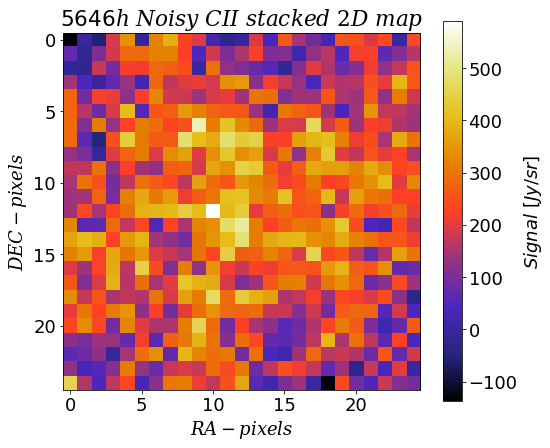

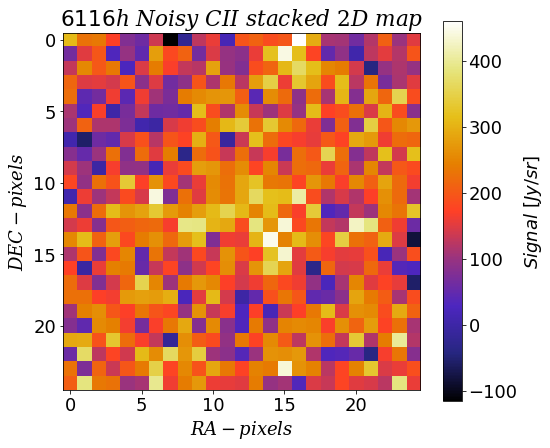

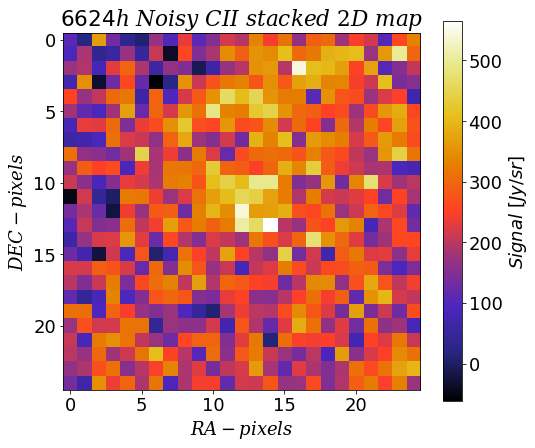

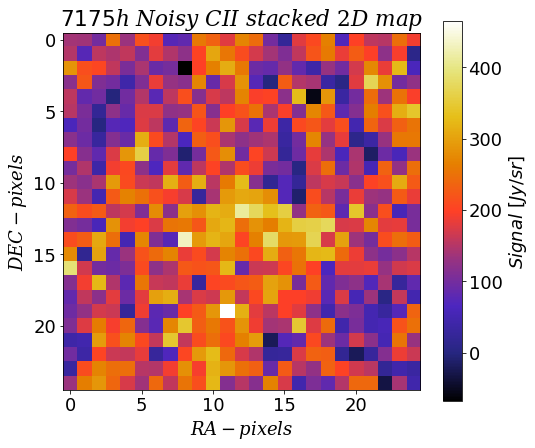

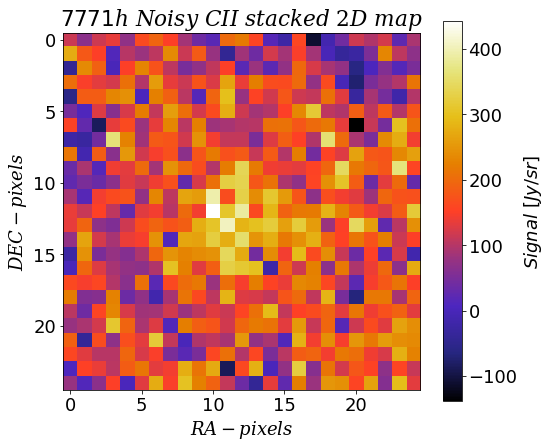

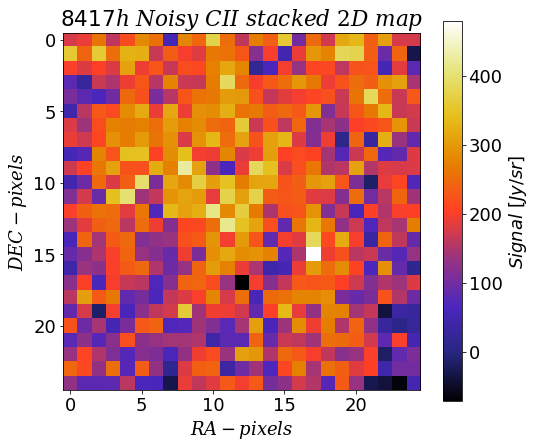

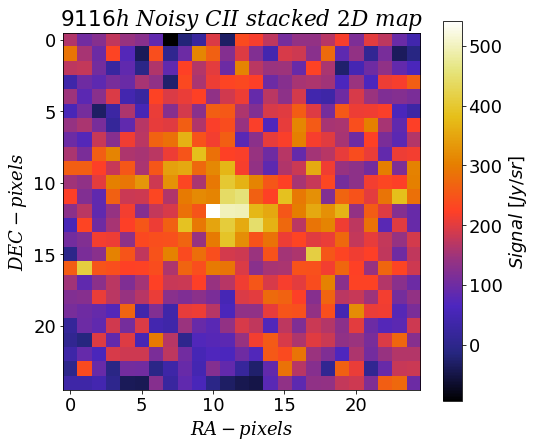

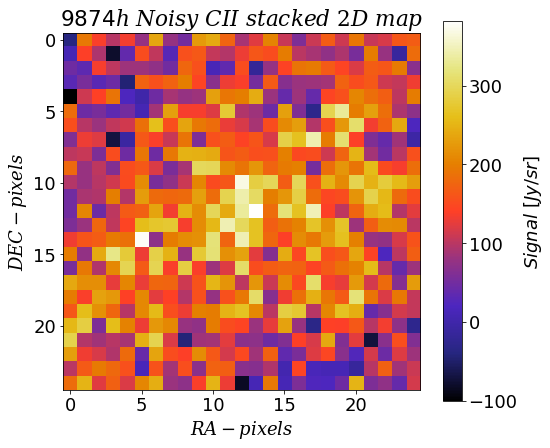

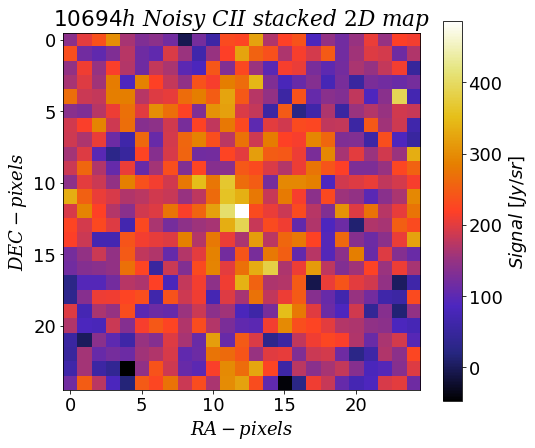

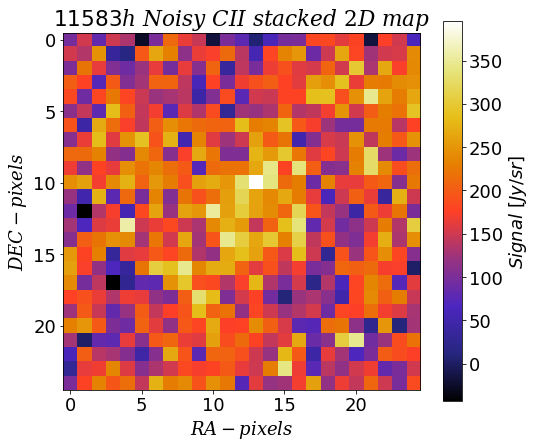

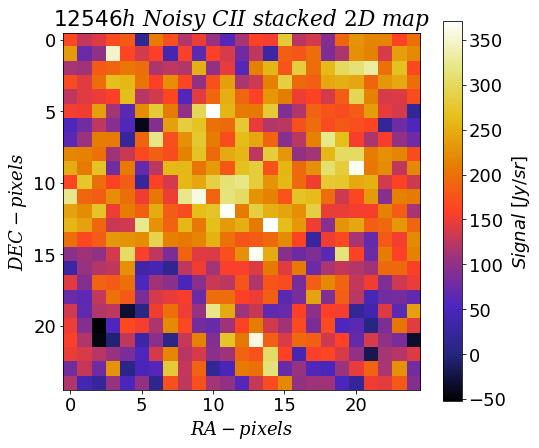

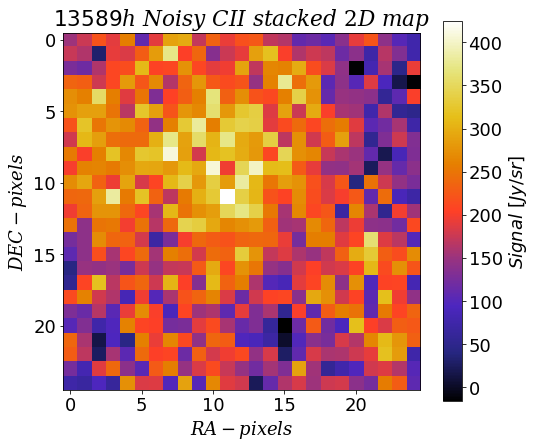

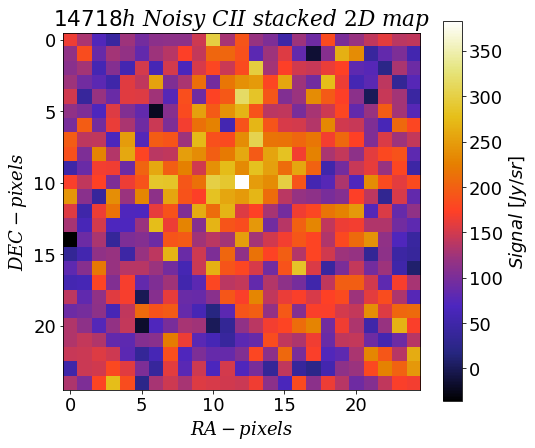

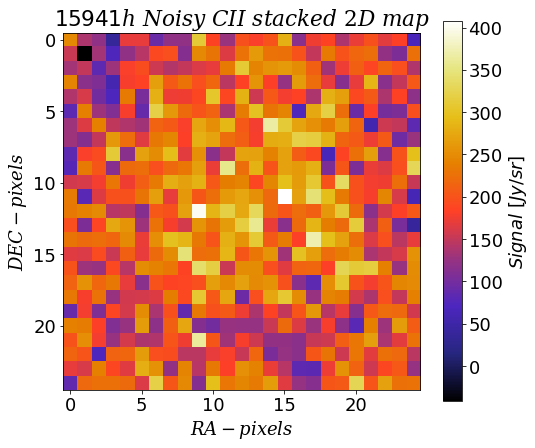

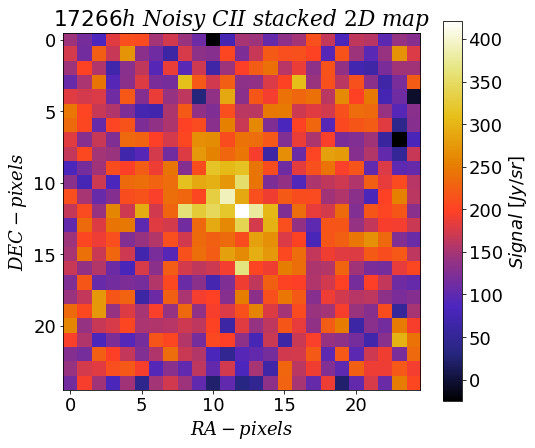

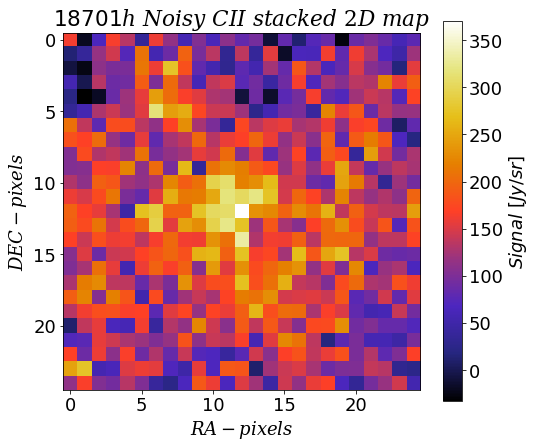

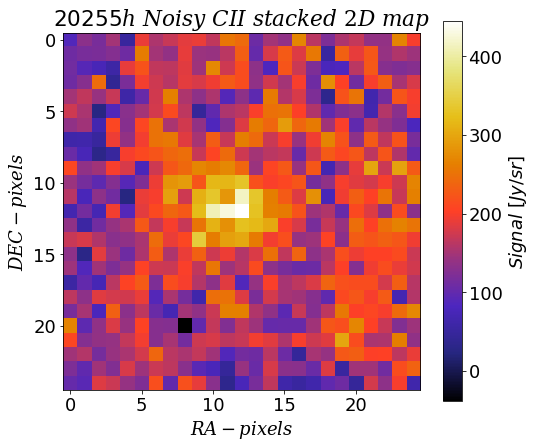

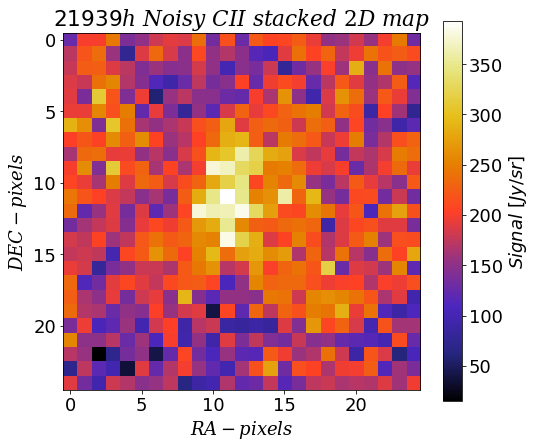

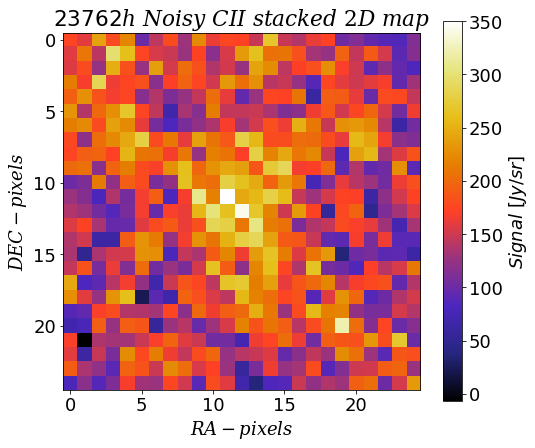

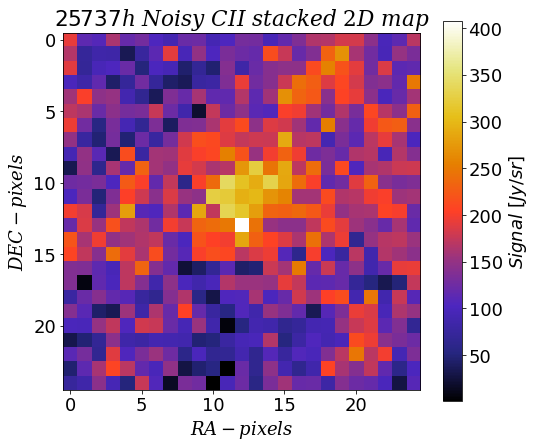

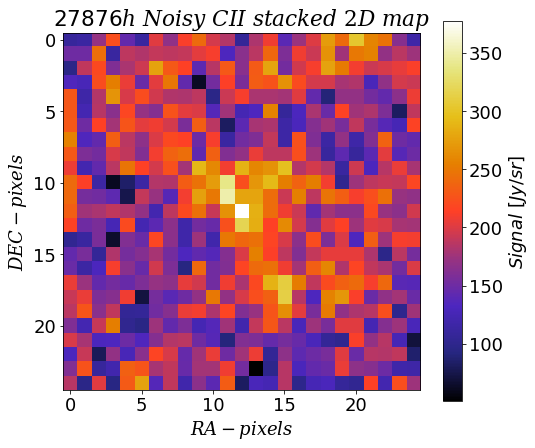

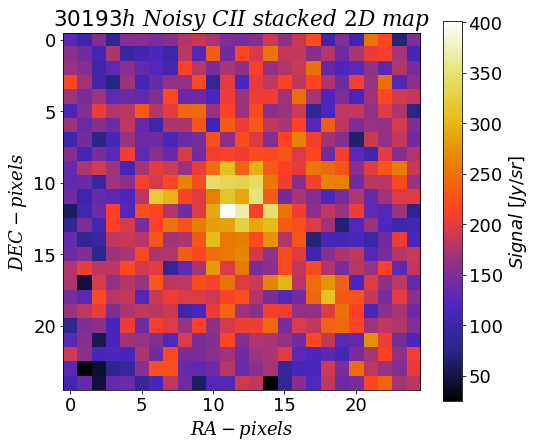

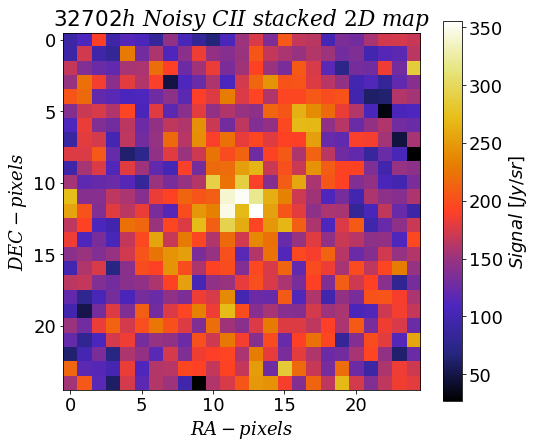

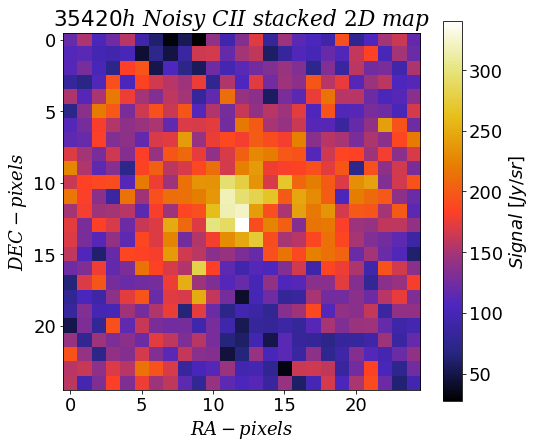

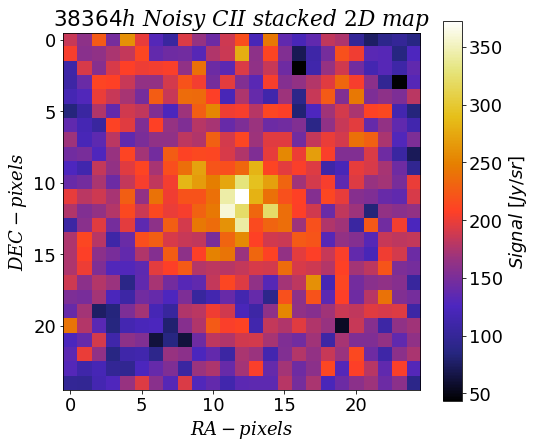

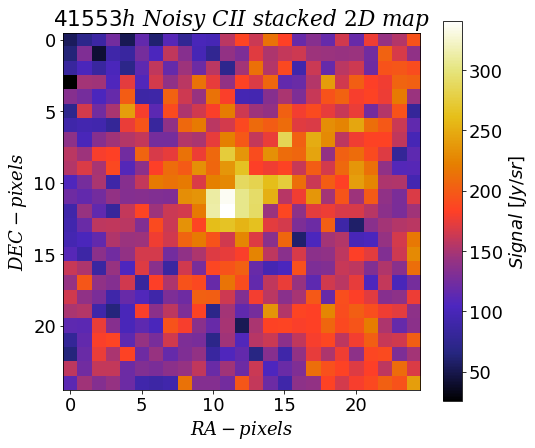

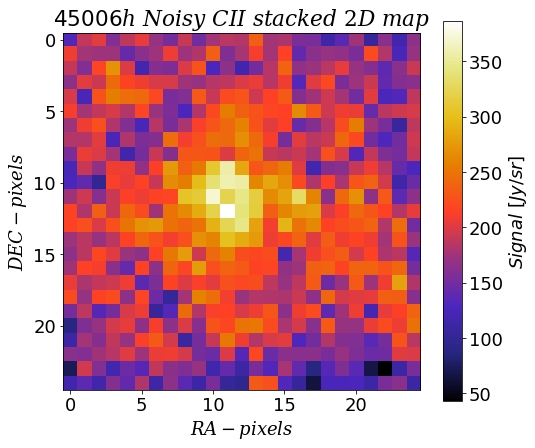

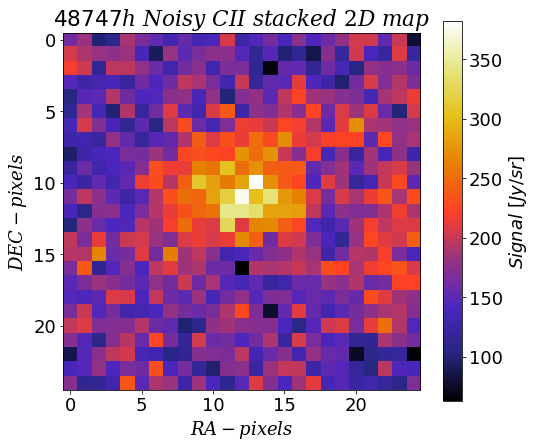

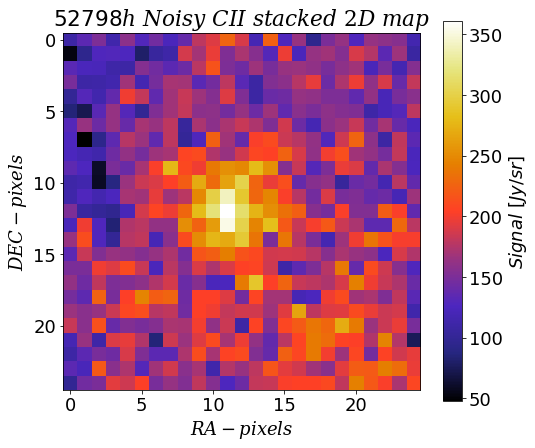

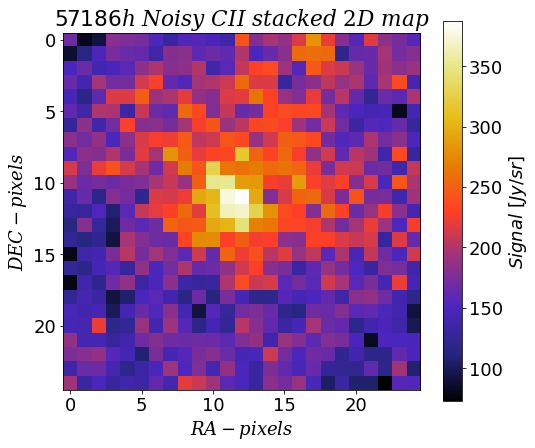

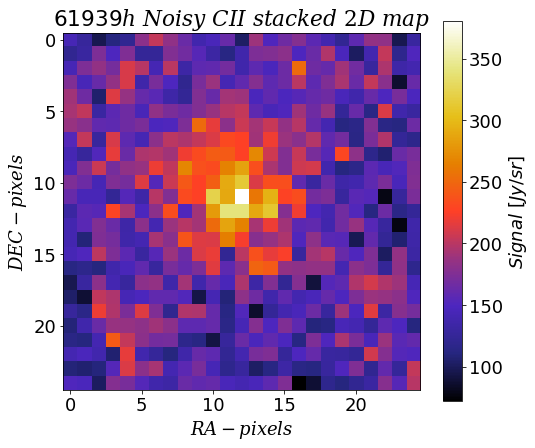

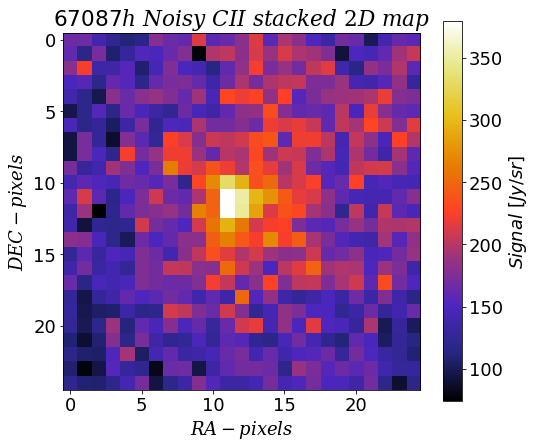

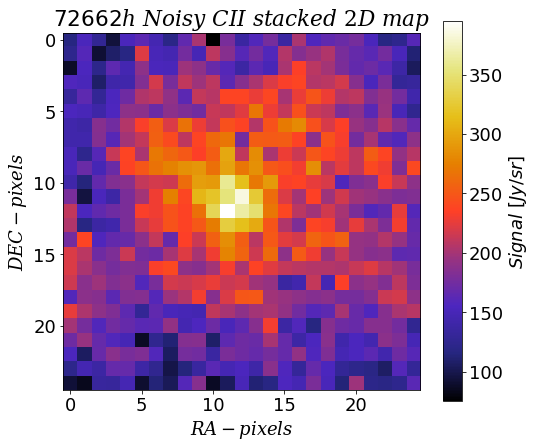

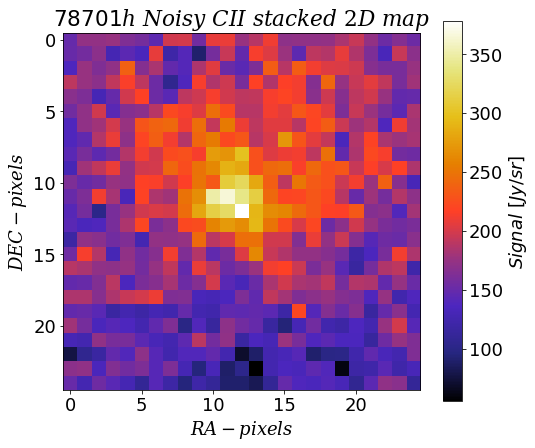

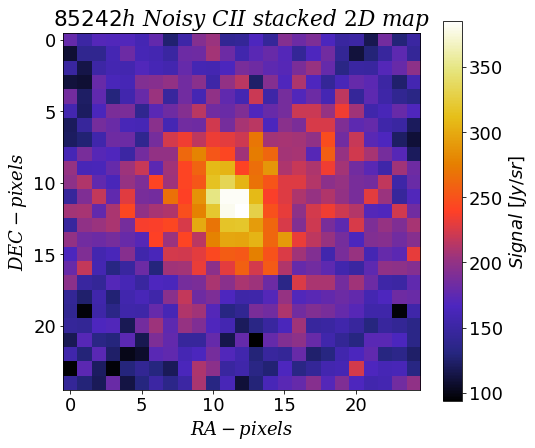

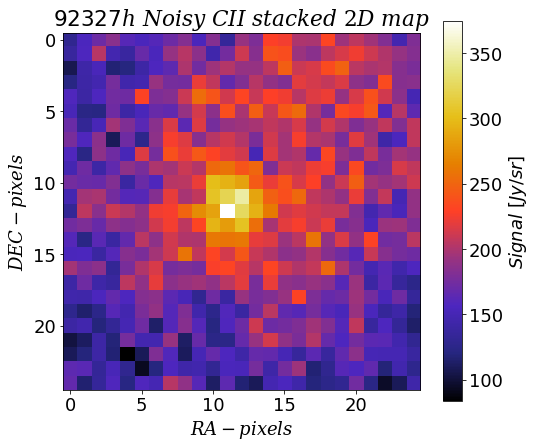

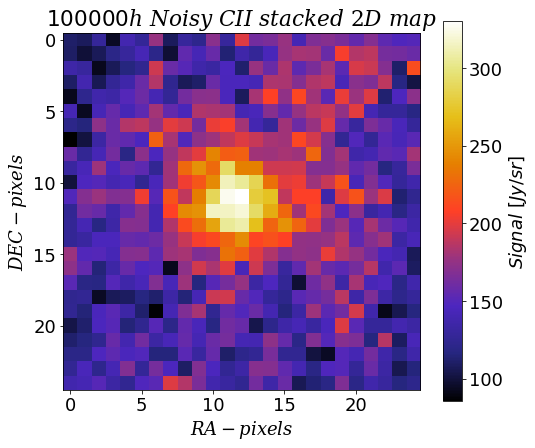

In [520]:
for i in range(len(t_obs_arr_2)):

    plt.imshow(np.nanmean(noisy_stacks_mov[i], axis = 0), cmap = 'CMRmap')
    plt.colorbar(label = r'$Signal\ [Jy/sr]$')
    plt.title(str(round(t_obs_arr_2[i]))+r'$h\ Noisy\ CII\ stacked\ 2D\ map$', math_fontfamily = 'dejavuserif')
    plt.xlabel(r'$RA-pixels$', math_fontfamily='dejavuserif')
    plt.ylabel(r'$DEC-pixels$', math_fontfamily='dejavuserif')
    
    plt.savefig(str(i)+'.png')
    plt.show()

In [524]:
with imageio.get_writer('stacked.gif', mode='I') as writer:
    for filename in list_stack:
        image = imageio.imread(filename)
        writer.append_data(image)

/tmp/ipykernel_962850/510766171.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [521]:
list_stack = [str(i)+'.png' for i in range(len(t_obs_arr_2))]

In [522]:
list_stack

['0.png',
 '1.png',
 '2.png',
 '3.png',
 '4.png',
 '5.png',
 '6.png',
 '7.png',
 '8.png',
 '9.png',
 '10.png',
 '11.png',
 '12.png',
 '13.png',
 '14.png',
 '15.png',
 '16.png',
 '17.png',
 '18.png',
 '19.png',
 '20.png',
 '21.png',
 '22.png',
 '23.png',
 '24.png',
 '25.png',
 '26.png',
 '27.png',
 '28.png',
 '29.png',
 '30.png',
 '31.png',
 '32.png',
 '33.png',
 '34.png',
 '35.png',
 '36.png',
 '37.png',
 '38.png',
 '39.png',
 '40.png',
 '41.png',
 '42.png',
 '43.png',
 '44.png',
 '45.png',
 '46.png',
 '47.png',
 '48.png',
 '49.png']

Working well but need to do linspace interval

Linspace now...

In [525]:
t_obs_arr_3 = np.linspace(2000, 1000000, 100)

In [527]:
noisy_stacks_mov2     = [[] for i in range(len(t_obs_arr_3))]
noiseless_stacks_mov2 = [[] for i in range(len(t_obs_arr_3))]

for i in range(len(t_obs_arr_3)):

    llm_obj.update(tobs = (t_obs_arr_3[i])*u.hr)
    
    noisy_stacks_mov2[i], noiseless_stacks_mov2[i] = lum(25, halo_xs, halo_ys)

Loading .npz catalogues...
14189.242531292331
Loading .npz catalogues...
5773.327807761516
Loading .npz catalogues...
4262.589349793107
Loading .npz catalogues...
3533.9497166742854
Loading .npz catalogues...
3084.5001496296354
Loading .npz catalogues...
2771.991048089929
Loading .npz catalogues...
2538.5565904161863
Loading .npz catalogues...
2355.638508618912
Loading .npz catalogues...
2207.303589571836
Loading .npz catalogues...
2083.869251727297
Loading .npz catalogues...
1979.0673948862889
Loading .npz catalogues...
1888.637508573934
Loading .npz catalogues...
1809.569044757068
Loading .npz catalogues...
1739.6662820168901
Loading .npz catalogues...
1677.285073060678
Loading .npz catalogues...
1621.1665981386113
Loading .npz catalogues...
1570.328525669611
Loading .npz catalogues...
1523.9915331605853
Loading .npz catalogues...
1481.5283672623887
Loading .npz catalogues...
1442.4277029520026
Loading .npz catalogues...
1406.2679750946236
Loading .npz catalogues...
1372.698085451908